In [ ]:
#Phan Trần Sơn Bảo
#DS001
#MSSV: 31201024456

#ĐỌC VÀ TIỀN XỬ LÍ

In [46]:
import gensim
import re
import pandas as pd  
import numpy as np
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Import unquote to prevent url encoding errors in next_results
import json
from urllib.parse import unquote
from datetime import datetime, timedelta
import numpy as np
# XXX: Set this variable to a trending topic, 
# or anything else for that matter. The example query below
# was a trending topic when this content was being developed
# and is used throughout the remainder of this chapter.
from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()
def load_data3():
    csv = '/content/drive/MyDrive/Colab Notebooks/BigData/KiemTra/autolabel_2728_Trump.Kim.csv'
    my_df = pd.read_csv(csv)
    #my_df.dropna(inplace=True)
    #my_df.reset_index(drop=True,inplace=True)
    my_df = my_df.rename(columns={'Tweets\n{Realtime from API Twitter}': 'Tweets', 'Clean_Tweets\n{After Clean Tweets}': 'Clean_Tweets',
                            'DeepLearing\n{Predict based on Model Trained}': 'DeepLearing', 'SentimentWordNet\n{ <0 - negative, >0 - positive}': 'SentimentWordNet',
                            'SentimentCoreNLP\n{0 - negative, 4 - positive}':'SentimentCoreNLP'})
    return my_df


In [4]:
tw = load_data3();

In [ ]:
tw['Tweets'] = tw['Tweets'].astype(str)
tw['Clean_Tweets'] = tw['Tweets'].apply(tweet_cleaner)

In [ ]:
tw.head()

#DEEP LEARNING

In [7]:
EMBEDDING_DIM = 100

modelW2V = gensim.models.Word2Vec.load("/content/drive/MyDrive/Colab Notebooks/BigData/KiemTra/AutoSentiment/word2vec.model")
embedding_matrix = np.zeros((len(modelW2V.wv.vocab)+1, EMBEDDING_DIM))
word2index = {}
embedding_matrix[0]=np.zeros( EMBEDDING_DIM)
for i in range(len(modelW2V.wv.vocab)):
    embedding_vector = modelW2V.wv[modelW2V.wv.index2word[i]]
    if embedding_vector is not None:
        embedding_matrix[i+1] = embedding_vector
        word2index[modelW2V.wv.index2word[i]] = i+1

In [9]:
MAX_SEQUENCE_LENGTH = 100 

In [10]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import LSTM, Convolution1D, Flatten, Dropout
from tensorflow.keras.callbacks import TensorBoard

model = Sequential()
model.add(Embedding(input_dim=embedding_matrix.shape[0],
                            output_dim=embedding_matrix.shape[1], 
                            input_length=MAX_SEQUENCE_LENGTH,
                            weights=[embedding_matrix], 
                            trainable=False))
model.add(LSTM(100,input_shape=(MAX_SEQUENCE_LENGTH, 1))) 
#model.add(Flatten())

model.add(Dense(128,activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))

model.add(Dense(1,activation='tanh'))
model.load_weights('/content/drive/MyDrive/Colab Notebooks/BigData/KiemTra/AutoSentiment/model_trained_full.h5')

In [11]:
import gensim
import re
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import LSTM, Convolution1D, Flatten, Dropout
from tensorflow.keras.callbacks import TensorBoard
from bs4 import BeautifulSoup

In [12]:
dl_tw = tw[['Clean_Tweets', 'DeepLearing']]

In [13]:
def Sentiment_offline(df):
    for index, row in df.iterrows():
        indices = []
        for w in row['Clean_Tweets'].split():
            if w in modelW2V.wv.vocab:
                indices.append(word2index[re.sub(r'[^\w\s]','',w).lower()])
        data_pad = pad_sequences([indices], maxlen=MAX_SEQUENCE_LENGTH)
        scores = model.predict(data_pad)
        df.at[index, 'DeepLearing'] = scores.item(0)

In [14]:
Sentiment_offline(dl_tw);

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
1/1 [==============================] - 0s 27ms/step


In [17]:
dl_tw['DeepLearing'] = dl_tw['DeepLearing'].apply(lambda x : 'positive' if x > 0 else 'negative')

<ipython-input-17-33b030a8a500>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dl_tw['DeepLearing'] = dl_tw['DeepLearing'].apply(lambda x : 'positive' if x > 0 else 'negative')


In [18]:
dl_tw['DeepLearing'].value_counts()

positive    7807
negative    3871
Name: DeepLearing, dtype: int64

In [21]:
tw['DeepLearing'] = dl_tw['DeepLearing']
tw.head()

,#,Tweets,Clean_Tweets,DeepLearing,SentimentWordNet,SentimentCoreNLP
0,1,@realDonaldTrump Exactly! They're nothing but ...,exactly they re nothing but liars,negative,NaN,NaN
1,2,@realDonaldTrump Tremendous crowds? ?,tremendous crowds,negative,NaN,NaN
2,3,@DrDenaGrayson @realDonaldTrump So you want war?,so you want war,positive,NaN,NaN
3,4,@Sevronosaurus @BashAlaniz @hahaohman @Sanchob...,no it was,negative,NaN,NaN
4,5,@realDonaldTrump You are aiding and abetting a...,you are aiding and abetting an international c...,positive,NaN,NaN


#SENTIMENTNETWORD

In [22]:
snw = tw[['Clean_Tweets']]
snw.head()

,Clean_Tweets
0,exactly they re nothing but liars
1,tremendous crowds
2,so you want war
3,no it was
4,you are aiding and abetting an international c...


In [23]:
class SentimentAnalysis(object):
    """Class to get sentiment score based on analyzer."""

    def __init__(self, filename='SentiWordNet.txt', weighting='geometric'):
        """Initialize with filename and choice of weighting."""
        if weighting not in ('geometric', 'harmonic', 'average'):
            raise ValueError(
                'Allowed weighting options are geometric, harmonic, average')
        # parse file and build sentiwordnet dicts
        self.swn_pos = {'a': {}, 'v': {}, 'r': {}, 'n': {}}
        self.swn_all = {}
        self.build_swn(filename, weighting)

    def average(self, score_list):
        """Get arithmetic average of scores."""
        if(score_list):
            return sum(score_list) / float(len(score_list))
        else:
            return 0

    def geometric_weighted(self, score_list):
        """"Get geometric weighted sum of scores."""
        weighted_sum = 0
        num = 1
        for el in score_list:
            weighted_sum += (el * (1 / float(2**num)))
            num += 1
        return weighted_sum

    # another possible weighting instead of average
    def harmonic_weighted(self, score_list):
        """Get harmonic weighted sum of scores."""
        weighted_sum = 0
        num = 2
        for el in score_list:
            weighted_sum += (el * (1 / float(num)))
            num += 1
        return weighted_sum

    def build_swn(self, filename, weighting):
        """Build class's lookup based on SentiWordNet 3.0."""
        records = [line.split('\t') for line in open(filename)]
        for rec in records:
            # has many words in 1 entry
            words = rec[4].split()
            pos = rec[0]
            for word_num in words:
                word = word_num.split('#')[0]
                sense_num = int(word_num.split('#')[1])

                # build a dictionary key'ed by sense number
                if word not in self.swn_pos[pos]:
                    self.swn_pos[pos][word] = {}
                self.swn_pos[pos][word][sense_num] = float(
                    rec[2]) - float(rec[3])
                if word not in self.swn_all:
                    self.swn_all[word] = {}
                self.swn_all[word][sense_num] = float(rec[2]) - float(rec[3])

        # convert innermost dicts to ordered lists of scores
        for pos in self.swn_pos.keys():
            for word in self.swn_pos[pos].keys():
                newlist = [self.swn_pos[pos][word][k] for k in sorted(
                    self.swn_pos[pos][word].keys())]
                if weighting == 'average':
                    self.swn_pos[pos][word] = self.average(newlist)
                if weighting == 'geometric':
                    self.swn_pos[pos][word] = self.geometric_weighted(newlist)
                if weighting == 'harmonic':
                    self.swn_pos[pos][word] = self.harmonic_weighted(newlist)

        for word in self.swn_all.keys():
            newlist = [self.swn_all[word][k] for k in sorted(
                self.swn_all[word].keys())]
            if weighting == 'average':
                self.swn_all[word] = self.average(newlist)
            if weighting == 'geometric':
                self.swn_all[word] = self.geometric_weighted(newlist)
            if weighting == 'harmonic':
                self.swn_all[word] = self.harmonic_weighted(newlist)

    def pos_short(self, pos):
        """Convert NLTK POS tags to SWN's POS tags."""
        if pos in set(['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']):
            return 'v'
        elif pos in set(['JJ', 'JJR', 'JJS']):
            return 'a'
        elif pos in set(['RB', 'RBR', 'RBS']):
            return 'r'
        elif pos in set(['NNS', 'NN', 'NNP', 'NNPS']):
            return 'n'
        else:
            return 'a'

    def score_word(self, word, pos):
        """Get sentiment score of word based on SWN and part of speech."""
        try:
            return self.swn_pos[pos][word]
        except KeyError:
            try:
                return self.swn_all[word]
            except KeyError:
                return 0

    def score(self, sentence):
        """Sentiment score a sentence."""
        # init sentiwordnet lookup/scoring tools
        impt = set(['NNS', 'NN', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS',
                    'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN',
                    'VBP', 'VBZ', 'unknown'])
        non_base = set(['VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'NNS', 'NNPS'])
        negations = set(['not', 'n\'t', 'less', 'no', 'never',
                         'nothing', 'nowhere', 'hardly', 'barely',
                         'scarcely', 'nobody', 'none'])
        stopwords = nltk.corpus.stopwords.words('english')
        wnl = nltk.WordNetLemmatizer()

        scores = []
        tokens = nltk.tokenize.word_tokenize(sentence)
        tagged = nltk.pos_tag(tokens)

        index = 0
        for el in tagged:

            pos = el[1]
            try:
                word = re.match('(\w+)', el[0]).group(0).lower()
                start = index - 5
                if start < 0:
                    start = 0
                neighborhood = tokens[start:index]

                # look for trailing multiword expressions
                word_minus_one = tokens[index-1:index+1]
                word_minus_two = tokens[index-2:index+1]

                # if multiword expression, fold to one expression
                if(self.is_multiword(word_minus_two)):
                    if len(scores) > 1:
                        scores.pop()
                        scores.pop()
                    if len(neighborhood) > 1:
                        neighborhood.pop()
                        neighborhood.pop()
                    word = '_'.join(word_minus_two)
                    pos = 'unknown'

                elif(self.is_multiword(word_minus_one)):
                    if len(scores) > 0:
                        scores.pop()
                    if len(neighborhood) > 0:
                        neighborhood.pop()
                    word = '_'.join(word_minus_one)
                    pos = 'unknown'

                # perform lookup
                if (pos in impt) and (word not in stopwords):
                    if pos in non_base:
                        word = wnl.lemmatize(word, self.pos_short(pos))
                    score = self.score_word(word, self.pos_short(pos))
                    if len(negations.intersection(set(neighborhood))) > 0:
                        score = -score
                    scores.append(score)

            except AttributeError:
                pass

            index += 1

        if len(scores) > 0:
            return sum(scores) / float(len(scores))
        else:
            return 0

    def is_multiword(self, words):
        """Test if a group of words is a multiword expression."""
        joined = '_'.join(words)
        return joined in self.swn_all

In [24]:
import nltk
from nltk.corpus import sentiwordnet as swn
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('sentiwordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.


True

In [25]:
def score_tw(doc):
  sentences = nltk.sent_tokenize(doc)
  stokens = [nltk.word_tokenize(sent) for sent in sentences]
  taggedlist=[]
  for stoken in stokens:        
      taggedlist.append(nltk.pos_tag(stoken))
  wnl = nltk.WordNetLemmatizer()

  score_list=[]
  for idx,taggedsent in enumerate(taggedlist):
      score_list.append([])
      for idx2,t in enumerate(taggedsent):
          newtag=''
          lemmatized=wnl.lemmatize(t[0])
          if t[1].startswith('NN'):
              newtag='n'
          elif t[1].startswith('JJ'):
              newtag='a'
          elif t[1].startswith('V'):
              newtag='v'
          elif t[1].startswith('R'):
              newtag='r'
          else:
              newtag=''       
          if(newtag!=''):    
              synsets = list(swn.senti_synsets(lemmatized, newtag))
              #Getting average of all possible sentiments, as you requested        
              score=0
              if(len(synsets)>0):
                  for syn in synsets:
                      score+=syn.pos_score()-syn.neg_score()
                  score_list[idx].append(score/len(synsets))
              
  sentence_sentiment=[]

  for score_sent in score_list:
    if len(score_sent) == 0:
      #sentence_sentiment.append(0)
      continue
    else:
      sentence_sentiment.append(sum([word_score for word_score in score_sent])/len(score_sent))
  return sentence_sentiment

In [26]:
score = []
for i in snw['Clean_Tweets']:
  score.append(score_tw(i))

In [27]:
score = pd.Series(score, name='SentimentWordNet')
snw = pd.concat([snw, score], axis=1)
snw['SentimentWordNet'] = snw['SentimentWordNet'].apply(lambda x: x[0] if len(x) > 0 else 0.0)

In [28]:
snw['SentimentWordNet'] = snw['SentimentWordNet'].apply(lambda x : 'positive' if x > 0 else 'negative')
snw.head()

,Clean_Tweets,SentimentWordNet
0,exactly they re nothing but liars,negative
1,tremendous crowds,positive
2,so you want war,negative
3,no it was,negative
4,you are aiding and abetting an international c...,negative


In [29]:
snw['SentimentWordNet'].value_counts()

negative    6118
positive    5560
Name: SentimentWordNet, dtype: int64

In [30]:
tw['SentimentWordNet'] = snw['SentimentWordNet']
tw.head()

,#,Tweets,Clean_Tweets,DeepLearing,SentimentWordNet,SentimentCoreNLP
0,1,@realDonaldTrump Exactly! They're nothing but ...,exactly they re nothing but liars,negative,negative,NaN
1,2,@realDonaldTrump Tremendous crowds? ?,tremendous crowds,negative,positive,NaN
2,3,@DrDenaGrayson @realDonaldTrump So you want war?,so you want war,positive,negative,NaN
3,4,@Sevronosaurus @BashAlaniz @hahaohman @Sanchob...,no it was,negative,negative,NaN
4,5,@realDonaldTrump You are aiding and abetting a...,you are aiding and abetting an international c...,positive,negative,NaN


#SENTIMENTCORENLP

In [32]:
scnlp = tw[['Clean_Tweets']]

In [33]:
scnlp.head()

,Clean_Tweets
0,exactly they re nothing but liars
1,tremendous crowds
2,so you want war
3,no it was
4,you are aiding and abetting an international c...


In [34]:
!pip install pycorenlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pycorenlp: filename=pycorenlp-0.3.0-py3-none-any.whl size=2142 sha256=438b3a2711cfe44e29bb254d54e324992ceadc37f6ba0b471ccff7ca66eb3fd1
  Stored in directory: /root/.cache/pip/wheels/99/43/83/53a89b5afcfe4bdaeec4ef0ff54ab0e09d6d3683d2884d1b4d
Successfully built pycorenlp


In [35]:
!apt-get install wget
!wget http://nlp.stanford.edu/software/stanford-corenlp-full-2018-10-05.zip
!unzip stanford-corenlp-full-2018-10-05.zip
!pip install stanfordcorenlp
!java -mx5g -cp "stanford-corenlp-full-2018-10-05/*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 15000

Reading package lists... Done
Building dependency tree       
Reading state information... Done
wget is already the newest version (1.20.3-1ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
--2023-03-18 12:57:59--  http://nlp.stanford.edu/software/stanford-corenlp-full-2018-10-05.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/software/stanford-corenlp-full-2018-10-05.zip [following]
--2023-03-18 12:57:59--  https://nlp.stanford.edu/software/stanford-corenlp-full-2018-10-05.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://downloads.cs.stanford.edu/nlp/software/stanford-corenlp-full-2018-10-05.zip [following]
--2023-03-18 12:57:59--  https://downloads.cs.stanford.edu/nlp/softw

In [79]:
from stanfordcorenlp import StanfordCoreNLP
import logging

logging.basicConfig(level=logging.DEBUG)
nlp = StanfordCoreNLP(r'stanford-corenlp-full-2018-10-05')

In [80]:
import json

sentiments = []
for tweet in scnlp['Clean_Tweets']:
    res = nlp.annotate(tweet,
                   properties={
                                'annotators': 'sentiment',
                                'outputFormat': 'json',
                                'timeout': 1000,
                              })
    try:
        res_dict = json.loads(res)
        sentiment = float(res_dict["sentences"][0]["sentimentValue"])
        sentiments.append(sentiment)
    except (ValueError, KeyError, IndexError):
        pass

In [89]:
score_sentiments = pd.Series(sentiments, name='SentimentCoreNLP')
scnlp = pd.concat([scnlp, score_sentiments], axis=1)
scnlp['SentimentCoreNLP'] = scnlp['SentimentCoreNLP'].apply(lambda x: 'positive' if x >= 2 else 'negative' if x <= 1 else 'can not sentiment')
#em search trên mạng thì nó bảo score 0,1 thì có thể xem là negative và 3,4 thì có thể xem là positive, còn 2 là neutral nhưng thầy không xét neutral nên em chọn số 2 là positive lun nha thầy.

In [90]:
scnlp.head()

,Clean_Tweets,SentimentCoreNLP
0,exactly they re nothing but liars,negative
1,tremendous crowds,positive
2,so you want war,positive
3,no it was,positive
4,you are aiding and abetting an international c...,negative


In [91]:
tw['SentimentCoreNLP'] = scnlp['SentimentCoreNLP']
tw.head()

,STT,Tweets,Clean_Tweets,DeepLearing,SentimentWordNet,SentimentCoreNLP
0,1,@realDonaldTrump Exactly! They're nothing but ...,exactly they re nothing but liars,negative,negative,negative
1,2,@realDonaldTrump Tremendous crowds? ?,tremendous crowds,negative,positive,positive
2,3,@DrDenaGrayson @realDonaldTrump So you want war?,so you want war,positive,negative,positive
3,4,@Sevronosaurus @BashAlaniz @hahaohman @Sanchob...,no it was,negative,negative,positive
4,5,@realDonaldTrump You are aiding and abetting a...,you are aiding and abetting an international c...,positive,negative,negative


#FINAL_RESULT VÀ IN RA FILE CSV

In [73]:
tw.rename(columns = {'#':'STT'}, inplace =True)

In [92]:
tw.head()

,STT,Tweets,Clean_Tweets,DeepLearing,SentimentWordNet,SentimentCoreNLP
0,1,@realDonaldTrump Exactly! They're nothing but ...,exactly they re nothing but liars,negative,negative,negative
1,2,@realDonaldTrump Tremendous crowds? ?,tremendous crowds,negative,positive,positive
2,3,@DrDenaGrayson @realDonaldTrump So you want war?,so you want war,positive,negative,positive
3,4,@Sevronosaurus @BashAlaniz @hahaohman @Sanchob...,no it was,negative,negative,positive
4,5,@realDonaldTrump You are aiding and abetting a...,you are aiding and abetting an international c...,positive,negative,negative


In [93]:
print(tw['DeepLearing'].value_counts())
print(tw['SentimentWordNet'].value_counts())
print(tw['SentimentCoreNLP'].value_counts())

positive    7807
negative    3871
Name: DeepLearing, dtype: int64
negative    6118
positive    5560
Name: SentimentWordNet, dtype: int64
positive             6024
negative             5454
can not sentiment     200
Name: SentimentCoreNLP, dtype: int64


In [94]:
writer = pd.ExcelWriter('result-PhanTranSonBao.xlsx')
tw.to_excel(writer)
writer.save()

#PHÂN TÍCH

In [54]:
nltk.download('words')
from nltk import ne_chunk
nltk.download('maxent_ne_chunker')
import nltk
nltk.download('words')
nltk.download('punkt')

from nltk import ne_chunk, pos_tag
from nltk.tokenize import word_tokenize
# Example text to be analyzed
def get_name(text):
  # Tokenize the text
  tokens = word_tokenize(text)

  # Tag the tokens with their parts of speech
  tagged_tokens = pos_tag(tokens)

  # Use the ne_chunk function to identify named entities
  ne_tree = ne_chunk(tagged_tokens)

  #print(ne_tree)
  # Iterate over the leaves of the named entity tree and print any identified named entities
  named_person_list = []
  named_country_list = []
  for subtree in ne_tree.subtrees():
      if subtree.label() == 'PERSON':
          named_person = ""
          for leaf in subtree.leaves():
              named_person += leaf[0] + " "
          named_person_list.append(named_person.strip())
  return named_person_list

def get_city(text):
  # Tokenize the text
  tokens = word_tokenize(text)

  # Tag the tokens with their parts of speech
  tagged_tokens = pos_tag(tokens)

  # Use the ne_chunk function to identify named entities
  ne_tree = ne_chunk(tagged_tokens)

  #print(ne_tree)
  # Iterate over the leaves of the named entity tree and print any identified named entities
  named_person_list = []
  named_country_list = []
  for subtree in ne_tree.subtrees():
      if subtree.label() == 'GPE':
          named_country = ""
          for leaf in subtree.leaves():
              named_country += leaf[0] + " "
          named_country_list.append(named_country.strip())

  return named_country_list

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [55]:
gn = tw['Tweets']
gn.head()

0    @realDonaldTrump Exactly! They're nothing but ...
1                @realDonaldTrump Tremendous crowds? ?
2     @DrDenaGrayson @realDonaldTrump So you want war?
3    @Sevronosaurus @BashAlaniz @hahaohman @Sanchob...
4    @realDonaldTrump You are aiding and abetting a...
Name: Tweets, dtype: object

In [56]:
list_name = []
list_city = []
for i in gn:
  list_name.append(get_name(i))
  list_city.append(get_city(i))

In [57]:
print(list_name)

[[], [], [], ['Sanchobuey'], [], ['Obama Trump Bernie', 'Hillary'], [], [], [], ['Trumpthey'], ['Trump'], ['Trump'], [], [], [], ['Low'], [], [], ['Mitch', 'Trump'], [], [], ['How'], ['Fund', 'Fund', 'Trump'], [], ['Trump'], [], ['Kim'], [], ['Donald Trump'], [], ['Trump'], ['Trump'], ['Kim585'], [], ['Twitter'], ['Trump'], [], ['Against Donald Trump'], ['Tillis'], [], ['Bannon Was Fly', 'Will Yet Deny'], [], [], [], ['Bone Spurs'], [], ['Trump'], [], ['Obama'], ['Obama'], ['Steve Mnuchinor Trump'], ['Trump'], [], ['Trump', 'Cohen'], ['Trump', 'Kim'], ['Gary', 'Cohn'], [], [], [], ['Trump'], ['Matt Gaetz'], [], [], ['Nick'], [], ['Baby'], [], [], [], [], ['Kim Jong Un', 'Kim'], ['Vietnam'], ['Kim Knows', 'Trump'], ['Twitter', 'Jack'], [], ['Vietnam', 'Party', 'Kim'], ['Tweet'], [], ['Trump', 'Border'], ['Trump'], [], [], ['Trumpyou'], ['Bullshite', 'Vietnam Vet McCain'], ['Sexy Young Lady'], ['Clinton', 'Bush'], ['Lol'], ['Michael', 'Cohen', 'Trump', 'Hager'], ['How'], [], [], ['Trump'

In [58]:
n = []
for i in list_name:
  for j in i:
    n.append(j)
df_n = pd.DataFrame(n, columns=['Names'])

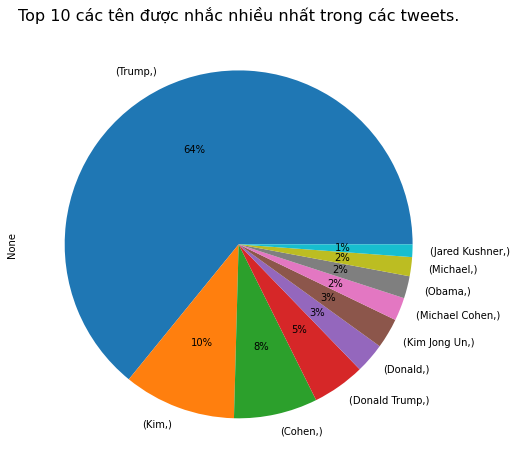

In [59]:
plt.figure(figsize = (16,8))
plt.title('Top 10 các tên được nhắc nhiều nhất trong các tweets.', fontsize = 16)
top_10 = df_n.value_counts().sort_values(ascending=False).head(10).plot(kind = 'pie', autopct = '%.f%%')
plt.show()

In [60]:
c = []
for i in list_city:
  for j in i:
    c.append(j)
df_c = pd.DataFrame(c, columns=['City'])

In [61]:
print(df_c.nunique())
unique = df_c['City'].unique().tolist()
print("Các thành phố được nhắc đến trong tweets là:", unique)

City    624
dtype: int64
Các thành phố được nhắc đến trong tweets là: ['SouthCarolina', 'San Antonio', 'Indian', 'Pence', 'Trump', 'Vietnam', 'HanoiVietnam', 'Pleasedo', 'North Korea', 'Good', 'Axios', 'Latest', 'Hanoi', 'Pelosi', 'Dictator', 'Korean', 'U.S.', 'Americans', 'Eliminated', 'Vox', 'Great', 'China', 'New York', 'US', 'Vietnamese', 'Chilli', 'Oistins', 'Msm', 'Washington', 'London', 'Saudi', 'Greatest', 'Pyoungyang', 'Cohen', 'Has', 'Fiverr', 'Steve', 'Approval', 'Russia', 'American', 'Southern', 'Wikileaks', 'Life', 'Venezuela', 'Hollywood', 'Wrong', 'Ottohis', 'Memphis', 'Los Angeles', 'America', 'Rocky', 'Cohens', 'Julian', 'Earth', 'Michael', 'NorthCarolina', 'Parenthoodcan', 'Russians', 'North', 'Dong Dang', 'United States', 'Iran', 'Pakistan', 'Haiti', 'Italy', 'South Korea', 'Clueless', 'Wow', 'Wait', 'Loser', 'Trumps', 'Newsweek', 'Love', 'Pyongyang', 'realDonaldTrump', 'North Korea Deal', 'T_D', 'Socialist', 'Nigerian', 'New', 'Watergate', 'Namhe', 'Fight', 'Tucker'

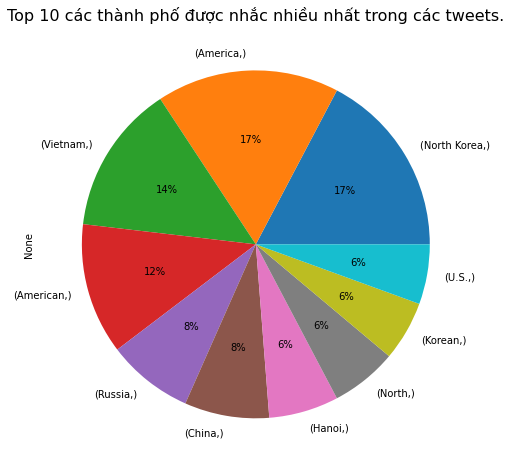

In [62]:
plt.figure(figsize = (16,8))
plt.title('Top 10 các thành phố được nhắc nhiều nhất trong các tweets.', fontsize = 16)
top_10 = df_c.value_counts().sort_values(ascending=False)[1:11].plot(kind = 'pie', autopct = '%.f%%')
plt.show()

In [116]:
def compare(df,col1, col2):
  df[col1 +' Compare '+col2] = df[col1] == df[col2]
  num_true = len(df[df[col1 +' Compare '+col2] == True])
  num_false = len(df[df[col1 +' Compare '+col2] == False])
  print(col1, 'so sánh với', col2,'thì có', num_true,'giá trị giống với', col2)
  print(col1, 'so sánh với', col2,'thì có', num_false,'giá trị khác với', col2)
  print('Tỷ lệ có values giống nhau:', (num_true/len(df))*100)

In [100]:
ana = tw.copy()
ana.head()

,STT,Tweets,Clean_Tweets,DeepLearing,SentimentWordNet,SentimentCoreNLP
0,1,@realDonaldTrump Exactly! They're nothing but ...,exactly they re nothing but liars,negative,negative,negative
1,2,@realDonaldTrump Tremendous crowds? ?,tremendous crowds,negative,positive,positive
2,3,@DrDenaGrayson @realDonaldTrump So you want war?,so you want war,positive,negative,positive
3,4,@Sevronosaurus @BashAlaniz @hahaohman @Sanchob...,no it was,negative,negative,positive
4,5,@realDonaldTrump You are aiding and abetting a...,you are aiding and abetting an international c...,positive,negative,negative


In [117]:
compare(ana, 'DeepLearing', 'SentimentWordNet')

DeepLearing so sánh với SentimentWordNet thì có 6951 giá trị giống với SentimentWordNet
DeepLearing so sánh với SentimentWordNet thì có 4727 giá trị khác với SentimentWordNet
Tỷ lệ có values giống nhau: 59.522178455214934


In [118]:
compare(ana, 'DeepLearing', 'SentimentCoreNLP')

DeepLearing so sánh với SentimentCoreNLP thì có 5883 giá trị giống với SentimentCoreNLP
DeepLearing so sánh với SentimentCoreNLP thì có 5795 giá trị khác với SentimentCoreNLP
Tỷ lệ có values giống nhau: 50.376776845350236


In [119]:
compare(ana, 'SentimentWordNet', 'SentimentCoreNLP')

SentimentWordNet so sánh với SentimentCoreNLP thì có 5759 giá trị giống với SentimentCoreNLP
SentimentWordNet so sánh với SentimentCoreNLP thì có 5919 giá trị khác với SentimentCoreNLP
Tỷ lệ có values giống nhau: 49.3149511902723
